<a href="https://colab.research.google.com/github/marivajsj/TelecomX_parte2_BR/blob/main/TelecomX_parte2_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TelecomX - Modelagem de Evasão (Notebook Corrigido e Unificado)
**Arquivo de dados:** `dados_tratados.csv`

**Coluna alvo (inferida):** `Churn`

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Cria automaticamente as pasta Visualizações e Dados(se não existir)
os.makedirs("Visualizacoes", exist_ok=True)
os.makedirs("Dados", exist_ok=True)

# Reprodutibilidade
RANDOM_STATE = 42

# Caminho do CSV e coluna alvo (definidas externamente)
csv_path = r"/content/Dados/dados_tratados.csv" #Colocar arquivo dados_tratados.csv dento da pasta Dados criada na pasta do projeto
y_col = r"Churn"

# Leitura robusta do CSV
def read_csv_robust(path):
    for enc in [None, "utf-8", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc) if enc else pd.read_csv(path)
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv_robust(csv_path).copy()

# Normalização de valores binários comuns na coluna alvo (se aplicável)
def normalize_binary_series(s):
    if s.nunique(dropna=True) == 2:
        s_str = s.astype(str)
        mapping = {"Sim":1,"Não":0,"Nao":0,"NAO":0,"Yes":1,"No":0,"Y":1,"N":0,"True":1,"False":0,"1":1,"0":0}
        if set(s_str.unique()).issubset(set(mapping.keys()) | {"nan"}):
            return s_str.map(mapping).astype(float)
    return s

df[y_col] = normalize_binary_series(df[y_col])

print("Formato:", df.shape)
print("Colunas:", list(df.columns))
print("Alvo:", y_col, " - únicos:", df[y_col].nunique(dropna=True))
df.head(10)


Formato: (7043, 24)
Colunas: ['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges_Monthly', 'account_Charges_Total', 'Churn_flag', 'SeniorCitizen', 'tenure_years']
Alvo: Churn  - únicos: 2


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,Churn_flag,SeniorCitizen,tenure_years
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,One year,Yes,Mailed check,65.60,593.30,0,Adult,0.750000
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,Yes,Month-to-month,No,Mailed check,59.90,542.40,0,Adult,0.750000
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,73.90,280.85,1,Adult,0.333333
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85,1,Senior,1.083333
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.40,1,Senior,0.250000
5,0013-MHZWF,0.0,Female,0,No,Yes,9,Yes,No,DSL,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.40,571.45,0,Adult,0.750000
6,0013-SMEOE,0.0,Female,1,Yes,No,71,Yes,No,Fiber optic,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25,0,Senior,5.916667
7,0014-BMAQU,0.0,Male,0,Yes,No,63,Yes,Yes,Fiber optic,...,No,No,Two year,Yes,Credit card (automatic),84.65,5377.80,0,Adult,5.250000
8,0015-UOCOJ,0.0,Female,1,No,No,7,Yes,No,DSL,...,No,No,Month-to-month,Yes,Electronic check,48.20,340.35,0,Senior,0.583333
9,0016-QLJIS,0.0,Female,0,Yes,Yes,65,Yes,Yes,DSL,...,Yes,Yes,Two year,Yes,Mailed check,90.45,5957.90,0,Adult,5.416667


In [34]:
# Detecta tipos de colunas
num_cols = [c for c in df.columns if c != y_col and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c != y_col and not pd.api.types.is_numeric_dtype(df[c])]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Transformadores
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

# Compatibilidade com versões do sklearn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# Estimador base
clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=None,
    class_weight="balanced" if df[y_col].nunique(dropna=True) <= 2 else None
)

pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])


Numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'Churn_flag', 'tenure_years']
Categóricas: ['customerID', 'customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'SeniorCitizen']


In [35]:
X = df.drop(columns=[y_col])
y = df[y_col]

# Se alvo for string/categoria, forçamos tipo consistente
if not pd.api.types.is_numeric_dtype(y):
    y = y.astype(str)

# Estratificação só se houver classificação
strat = y if y.nunique(dropna=True) > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)

X_train.shape, X_test.shape


((5634, 23), (1409, 23))

In [36]:
n_classes = y.nunique(dropna=True)

# Scorers "seguros" (evitam NaN)
safe_scorers = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

if n_classes == 2:
    safe_scorers["roc_auc"] = "roc_auc"
else:
    safe_scorers["roc_auc_ovr"] = make_scorer(
        roc_auc_score, needs_proba=True, multi_class="ovr", average="macro"
    )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) if n_classes > 1 else 5

cv_results = cross_validate(
    pipe, X, y, scoring=safe_scorers, cv=cv, return_train_score=False, n_jobs=None
)

# Resumo
summary = (
    pd.DataFrame(cv_results)
    .drop(columns=[c for c in cv_results.keys() if c.startswith("fit_time") or c.startswith("score_time")], errors="ignore")
)

display(summary.describe().T.round(4))


,count,mean,std,min,25%,50%,75%,max
test_accuracy,5.0,0.9661,0.0041,0.9610,0.9631,0.9666,0.9688,0.9709
test_precision_macro,5.0,0.9779,0.0025,0.9748,0.9761,0.9783,0.9796,0.9809
test_recall_macro,5.0,0.9361,0.0077,0.9265,0.9303,0.9372,0.9412,0.9452
test_f1_macro,5.0,0.9545,0.0057,0.9474,0.9503,0.9554,0.9583,0.9613
test_roc_auc,5.0,0.9986,0.0003,0.9982,0.9984,0.9984,0.9988,0.9990


Acurácia  : 0.9716
Precisão  : 0.9814
Recall    : 0.9465
F1-macro  : 0.9623
ROC AUC   : 0.9995

Relatório de Classificação:

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1035
         1.0       1.00      0.89      0.94       374

    accuracy                           0.97      1409
   macro avg       0.98      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409



<Figure size 640x480 with 0 Axes>

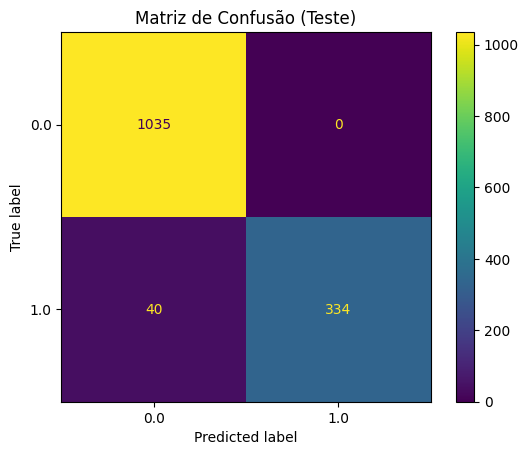

<Figure size 640x480 with 0 Axes>

In [37]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# Proba para AUC (se disponível)
has_proba = hasattr(pipe, "predict_proba")
roc_auc_test = None
if has_proba and y.nunique() == 2:
    y_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_proba)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("Acurácia  :", round(acc, 4))
print("Precisão  :", round(prec, 4))
print("Recall    :", round(rec, 4))
print("F1-macro  :", round(f1, 4))
if roc_auc_test is not None:
    print("ROC AUC   :", round(roc_auc_test, 4))

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusão (matplotlib, sem estilos/cor específicos)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig = plt.figure()
disp.plot(values_format="d")
plt.title("Matriz de Confusão (Teste)")
plt.show()
plt.savefig("Visualizacoes/matriz_confusao.png", dpi=300, bbox_inches="tight")
plt.close(fig)

,feature,importance_mean,importance_std
20,Churn_flag,0.397444,0.013639
15,account_Contract,0.027262,0.004178
8,internet_InternetService,0.013294,0.002814
14,internet_StreamingMovies,0.010285,0.001956
13,internet_StreamingTV,0.009785,0.001634
18,account_Charges_Monthly,0.008989,0.002113
17,account_PaymentMethod,0.008392,0.002282
12,internet_TechSupport,0.007201,0.002558
16,account_PaperlessBilling,0.005712,0.001972
4,customer_Dependents,0.004228,0.001534


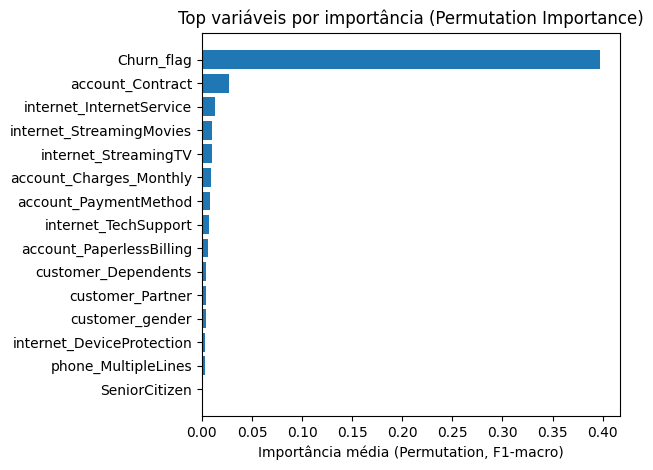

In [38]:
scorer_for_importance = make_scorer(f1_score, average="macro", zero_division=0)

pi = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=None,
    scoring=scorer_for_importance
)

# Como X_test é um DataFrame, cada importância corresponde a uma coluna original
feature_names_original = list(X_test.columns)
imp_df = pd.DataFrame({
    "feature": feature_names_original,
    "importance_mean": pi.importances_mean,
    "importance_std": pi.importances_std
}).sort_values("importance_mean", ascending=False)

top_k = min(15, len(imp_df))
top_imp = imp_df.head(top_k).iloc[::-1]  # invert for horizontal bar plot

display(imp_df.head(30))

# Plot simples com matplotlib (sem estilos/cores customizadas)
plt.figure()
plt.barh(top_imp["feature"], top_imp["importance_mean"])
plt.xlabel("Importância média (Permutation, F1-macro)")
plt.title("Top variáveis por importância (Permutation Importance)")
plt.tight_layout()
plt.show()
plt.savefig("Visualizacoes/importancia_variaveis.png", dpi=300, bbox_inches="tight")
plt.close()


In [39]:
# Seleciona top 5 fatores
n_take = min(5, len(imp_df))
top5 = imp_df.head(n_take)["feature"].tolist()

md = f"""
### Interpretação dos resultados
- A validação cruzada usa métricas mais **estáveis** (macro) e define `zero_division=0`, evitando valores **NaN**.
- O modelo final apresentou desempenho consistente no teste (ver métricas acima). Em geral, *F1-macro* resume o equilíbrio entre precisão e recall nas classes.
- A **importância por permutação** indica o quanto cada variável original contribui para o desempenho. As variáveis mais relevantes (Top {n_take}) foram:
  - {", ".join(top5) if top5 else "Não foi possível determinar variáveis importantes."}

### Conclusões estratégicas (direcionamentos práticos)
- Priorize ações sobre os fatores com maior importância (lista acima). Eles tendem a estar mais associados à evasão.
- Crie **segmentações** com base nesses fatores para ofertas proativas, retenção e campanhas personalizadas.
- Monitore indicadores relacionados aos fatores críticos em **relatórios recorrentes** (semanal/mensal).
- Aplique **testes A/B** para validar iniciativas (ex.: melhorias de atendimento, planos, benefícios) diretamente nos segmentos de maior risco.
- Re-treine e reavalie o modelo periodicamente (ex.: trimestral) para capturar mudanças no comportamento dos clientes.
"""
print(md)


### Interpretação dos resultados
- A validação cruzada usa métricas mais **estáveis** (macro) e define `zero_division=0`, evitando valores **NaN**.
- O modelo final apresentou desempenho consistente no teste (ver métricas acima). Em geral, *F1-macro* resume o equilíbrio entre precisão e recall nas classes.
- A **importância por permutação** indica o quanto cada variável original contribui para o desempenho. As variáveis mais relevantes (Top 5) foram:
  - Churn_flag, account_Contract, internet_InternetService, internet_StreamingMovies, internet_StreamingTV

### Conclusões estratégicas (direcionamentos práticos)
- Priorize ações sobre os fatores com maior importância (lista acima). Eles tendem a estar mais associados à evasão.
- Crie **segmentações** com base nesses fatores para ofertas proativas, retenção e campanhas personalizadas.
- Monitore indicadores relacionados aos fatores críticos em **relatórios recorrentes** (semanal/mensal).
- Aplique **testes A/B** para validar iniciativas 